In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
import tensorflow.keras.backend as kb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from time import time
import warnings
warnings.filterwarnings('ignore')

In [137]:
base = pd.read_csv('train.csv')
testing = pd.read_csv('test.csv')
print(base.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### ANALISIS DE VARIABLES

In [4]:
#PassengerId -> same
#Survived -> y response
#Pclass -> a one-hot
#Name -> interesante mirar tamaño nombre
#sex -> a dummy
#age -> same
#SibSp -> same
#Parch -> same
#Ticket -> mirar patrones y luego a one-hot
#Fare -> mirar patrones y luego decicir si transformacion o same
#Cabin -> mirar patrones y luego decidir
#Embarked -> a one-hot

In [5]:
#Survived
base['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
#Pclass
print(base['Pclass'].value_counts())
pd.crosstab(base['Pclass'],base['Survived'])

3    491
1    216
2    184
Name: Pclass, dtype: int64


Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


(array([ 30.,  96., 102.,  39.,  35.,  32.,   4.,   3.,   0.,   1.]),
 array([12., 19., 26., 33., 40., 47., 54., 61., 68., 75., 82.]),
 <a list of 10 Patch objects>)

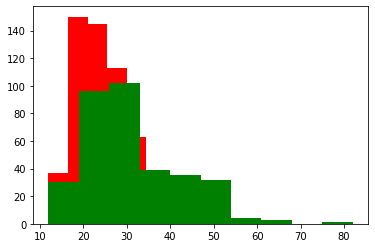

In [7]:
#Name
base['Name_length']=0
base['total_names']=0

for i in range(len(base['Name'])):
    base['Name_length'][i]=len(base['Name'][i])
    base['total_names'][i]=len(base['Name'][i].split())
plt.hist(base['Name_length'][base['Survived'] == 0],color='red')
plt.hist(base['Name_length'][base['Survived'] > 0],color='green')    

(array([216.,   0., 256.,   0.,  55.,   0.,  12.,   0.,   6.,   4.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

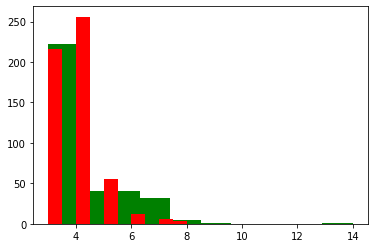

In [8]:
plt.hist(base['total_names'][base['Survived'] > 0],color='green')  
plt.hist(base['total_names'][base['Survived'] == 0],color='red')

In [9]:
#Sex
print(base['Sex'].value_counts())
pd.crosstab(base['Sex'],base['Survived'])

male      577
female    314
Name: Sex, dtype: int64


Survived,0,1
Sex,,
female,81,233
male,468,109


(array([36., 19., 63., 65., 52., 24., 21.,  9.,  0.,  1.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

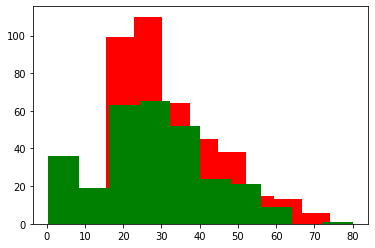

In [10]:
#Age
plt.hist(base['Age'][base['Survived'] == 0],color='red')
plt.hist(base['Age'][base['Survived'] > 0],color='green')

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


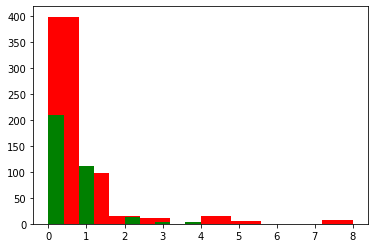

In [11]:
#SibSp -> pasar a one-hot de 0,1, 2 o mas
plt.hist(base['SibSp'][base['Survived'] == 0],color='red')
plt.hist(base['SibSp'][base['Survived'] > 0],color='green')
print(base['SibSp'].value_counts())
pd.crosstab(base['SibSp'],base['Survived'])

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


Survived,0,1
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


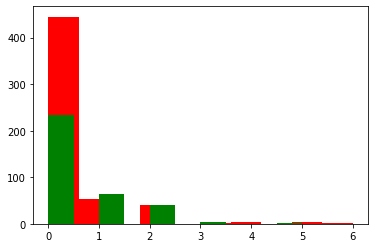

In [12]:
#Parch -> agrupar en 0 o 1
plt.hist(base['Parch'][base['Survived'] == 0],color='red')
plt.hist(base['Parch'][base['Survived'] > 0],color='green')
print(base['Parch'].value_counts())
pd.crosstab(base['Parch'],base['Survived'])

In [13]:
#Ticket -> pasar a len del tiquete y si tiene o no letras
print(base['Ticket'].value_counts())

1601        7
CA. 2343    7
347082      7
CA 2144     6
347088      6
           ..
36864       1
347069      1
350046      1
2648        1
343276      1
Name: Ticket, Length: 681, dtype: int64


(array([421.,  83.,  25.,   6.,   4.,   4.,   0.,   0.,   3.,   3.]),
 array([  0. ,  26.3,  52.6,  78.9, 105.2, 131.5, 157.8, 184.1, 210.4,
        236.7, 263. ]),
 <a list of 10 Patch objects>)

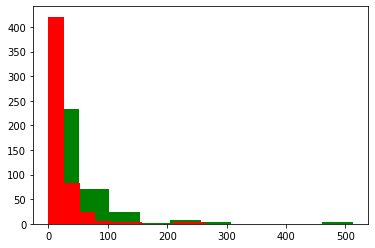

In [14]:
#Fare
plt.hist(base['Fare'][base['Survived'] > 0],color='green')
plt.hist(base['Fare'][base['Survived'] == 0],color='red')

In [15]:
#Cabin -> extraer los números, cantidad y las letras
print(base['Cabin'].value_counts())

B96 B98        4
C23 C25 C27    4
G6             4
D              3
E101           3
              ..
B39            1
A5             1
C70            1
E46            1
C128           1
Name: Cabin, Length: 147, dtype: int64


In [16]:
#Embarked -> a one-hot
print(base['Embarked'].value_counts())
pd.crosstab(base['Embarked'],base['Survived'])

S    644
C    168
Q     77
Name: Embarked, dtype: int64


Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


### DATA PREPROCESSING AND TRANSFORMING (IF NECESSARY)

In [142]:
def transform_and_prepare(base):
    #Pclass 
    base['Pclass_1'] = 0
    base['Pclass_2'] = 0
    base['Pclass_3'] = 0
    for i in range(len(base['Name'])):

        if base['Pclass'][i]==1:
            base['Pclass_1'][i]=1
        else:
            base['Pclass_1'][i]=0

        if base['Pclass'][i]==2:
            base['Pclass_2'][i]=1
        else:
            base['Pclass_2'][i]=0

        if base['Pclass'][i]==3:
            base['Pclass_3'][i]=1
        else:
            base['Pclass_3'][i]=0
        
    #Name
    base['Name_length']=0
    base['total_names']=0
    for i in range(len(base['Name'])):
        base['Name_length'][i]=len(base['Name'][i])
        base['total_names'][i]=len(base['Name'][i].split())
        
    #Sex
    le=preprocessing.LabelEncoder()
    base['Sex_num']=le.fit_transform(base['Sex'])
    
    #SibSp -> pasar a one-hot de 0,1, 2 o mas
    base['SibSp_0']=0
    base['SibSp_1']=0
    base['SibSp_2orMore']=0

    for i in range(len(base['Name'])):
        if base['SibSp'][i]==0 :
            base['SibSp_0'][i]=1
        else:
            base['SibSp_0'][i]=0

    for i in range(len(base['Name'])):
        if base['SibSp'][i]==1 :
            base['SibSp_1'][i]=1
        else:
            base['SibSp_1'][i]=0

    for i in range(len(base['Name'])):
        if base['SibSp'][i]>=2 :
            base['SibSp_2orMore'][i]=1
        else:
            base['SibSp_2orMore'][i]=0  
            
    #Parch -> agrupar en 0 o 1
    base['Parch_0'] = 0
    base['Parch_1'] = 0

    for i in range(len(base['Name'])):
        if base['Parch'][i]==0 :
            base['Parch_0'][i]=1
        else:
            base['Parch_0'][i]=0

    for i in range(len(base['Name'])):
        if base['Parch'][i]==1 :
            base['Parch_0'][i]=1
        else:
            base['Parch_0'][i]=0
            
    #Ticket -> pasar a len del tiquete y si tiene o no letras (por ahora solo len)
    base['leh_ticket'] = 0
    for i in range(len(base['Name'])):
        base['leh_ticket'][i]=len(base['Ticket'][i])
        
    #Cabin -> extraer los números, cantidad y las letras (por ahora solo cantidad)
    base['cant_cabin'] = 0
    for i in range(len(base['Name'])):
        base['cant_cabin'][i]=len(str(base['Cabin'][i]).split())
        
    #Embarked
    base['embarked_C'] = 0
    base['embarked_S'] = 0
    base['embarked_Q'] = 0
    for i in range(len(base['Name'])):

        if base['Embarked'][i]=='C':
            base['embarked_C'][i]=1
        else:
            base['embarked_C'][i]=0

        if base['Embarked'][i]=='S':
            base['embarked_S'][i]=1
        else:
            base['embarked_S'][i]=0

        if base['Embarked'][i]=='Q':
            base['embarked_Q'][i]=1
        else:
            base['embarked_Q'][i]=0
    
    X=base[['Age','Fare','Name_length',
       'total_names', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_num', 'SibSp_0',
       'SibSp_1', 'SibSp_2orMore', 'Parch_0', 'Parch_1', 'leh_ticket',
       'cant_cabin', 'embarked_C', 'embarked_S', 'embarked_Q']]
    try:
        y=base['Survived']
    except:
        y=0
        
    
    return X, y

In [143]:
X, y = transform_and_prepare(base)
X_testing, y_testing = transform_and_prepare(testing)

In [166]:
test_size = 50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

In [196]:
xg_reg = xgb.XGBRegressor(
                          booster='gbtree',
                          objective ='binary:logistic',
                          learning_rate = 0.01,
                          sampling_method='gradient_based',
                          colsample_bytree = 0.5, 
                          reg_lambda=100,
                          max_depth = 300, 
                          n_estimators = 1750,
                          eval_metric='auc'
        )

In [197]:
start=time()
xg_reg.fit(X_train,y_train)
end=time()
print('Execution Time :', (end - start), 's')

Execution Time : 2.2328460216522217 s


In [198]:
preds = xg_reg.predict(X_test)
preds_train = xg_reg.predict(X_train)

def convert_probs_to_preds(threshold, data):
    devolver=[]
    for i in range(len(data)):
        if data[i]>=threshold:
            devolver.append(1)
        else:
            devolver.append(0)
    return devolver

preds_final = convert_probs_to_preds(0.5, preds)
preds_train_final = convert_probs_to_preds(0.5, preds_train)

In [199]:
cm_train = confusion_matrix(y_train,preds_train_final)
cm_test = confusion_matrix(y_test,preds_final)
print('Train CM: \n',cm_train)
print('Test CM: \n',cm_test)

def acc(TP,TN,FP,FN):
    return (TP+TN)/(TP+TN+FP+FN)

print('Train Acc: ',acc(cm_train[0][0],cm_train[1][1],cm_train[0][1],cm_train[1][0]))
print('Val Acc: ',acc(cm_test[0][0],cm_test[1][1],cm_test[0][1],cm_test[1][0]))

Train CM: 
 [[479  36]
 [ 79 247]]
Test CM: 
 [[30  4]
 [ 5 11]]
Train Acc:  0.8632580261593341
Val Acc:  0.82


In [200]:
probs_test = xg_reg.predict(X_testing)
preds_test = convert_probs_to_preds(0.5, probs_test)
print(preds_test)

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 

In [201]:
np.array(preds_test).reshape(418,1)

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
    